# Analysis of Scalar measurement

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from utils import dB_to_U

# modify this based on where you open the notebook
PATH_TO_DATA = os.path.join(os.getcwd(), "data")
scalar_fname = "scalar_{0}.csv"

scalar_names = ["top", "side"]
scalar_data = []

# import data
for i, scalar_name in enumerate(scalar_names):
    # data has the following columns: resonant freq | rho at resonance | rho(omega0) unc | kappa_pos | kappa_neg | rho_hfwhm_pos | rho_hfwhm_neg | half fwhm | unc of rho at hfwhm
    data = np.genfromtxt(os.path.join(PATH_TO_DATA, scalar_fname.format(scalar_name)), delimiter=",", missing_values=np.nan, filling_values=np.nan, skip_header=1)
    scalar_data.append(data.T)

In [2]:
# define bunch of functions to evaluate relevant quantities

def coup_coeff(rho_res):
    '''coupling coefficient, evaluated from reflection coeff. at resonant frequency'''
    # need to have both positive and negative since we 
    # cannot tell if rho is >0 or <0 using scalar measurement
    kappa_pos = (1 + np.abs(rho_res)) / (1 - np.abs(rho_res))
    kappa_neg = 1 / kappa_pos

    return kappa_pos, kappa_neg

def rho_res_kappa(kappa):
    '''reflection coeff. at resonance evaluated from coupling coefficient. Used for verification.'''
    return np.abs((kappa - 1) / (kappa + 1))

def refl_hfwhm(kappa):
    '''reflection coefficient at half of FWHM using coupling coefficient'''
    return np.sqrt(kappa**2. + 1) / (kappa + 1)

def Q_factor(res_freq, hfwhm_freq):
    '''Loaded quality factor from resonant frequency and half of FWHM'''
    return res_freq / (2 * hfwhm_freq)

def Q0_factor(Q, kappa):
    '''Unloaded quality factor from loaded one and coupling coefficient'''
    return np.abs(1 + kappa) * Q

def rho_scalar(freq_shift, res_freq, kappa, Q0):
    '''Modulus of reflection coefficient as a function of frequency shift'''
    num = (kappa - 1)**2. + 4 * Q0**2. * (freq_shift / res_freq)**2.
    denom = (kappa + 1)**2. + 4 * Q0**2. * (freq_shift / res_freq)**2.
    return np.sqrt(num / denom)


In [3]:
# error propagation of kappa, rho(half fwhm), Q, Q0

def kappa_err(rho, rho_err):
    return 2 * rho_err / (1 + rho)**2.

def refl_hfwhm_err(kappa, kappa_err):
    return (kappa - 1) * kappa_err / ( (1 + kappa) * np.sqrt(kappa**2. + 1) )

def Q_err(res_freq, res_freq_err, half_fwhm, half_fwhm_err):
    return 0.5*np.sqrt((res_freq_err / half_fwhm)**2. + (res_freq * half_fwhm_err / half_fwhm**2. )**2.)

def Q0_err(Q, Q_err, kappa, kappa_err):
    return np.sqrt( (Q * kappa_err)**2. + (np.abs(1 + kappa) * Q_err)**2.)

In [4]:
# some things we need for the analysis

# analytic resonant frequencies obtained from prelab code
res_freqs_thr = np.array([2925400316.7974997,
 4661158820.126769,
 6247335097.000681,
 6715014401.315426,
 7761281300.353076]) * 1e-9  # in GHz 

# minimal stepsize in VNA
freq_err = 0.0000050  # GHz


Resonant frequencies / GHz for top coupling:  [2.99220687 4.53973125 6.21559375 6.940125   7.75975   ]
Residual with Theoretical values:  [0.06680656 0.12142757 0.03174135 0.2251106  0.0015313 ] 

Resonant frequencies / GHz for side coupling:  [2.98690625 4.49725    6.2078875  7.74540625]
Residual with Theoretical values:  [0.06150593 0.16390882 0.0394476  0.01587505] 

Differnce in resonance frequency between top and side coupling :  [0.00530062 0.04248125 0.00770625 0.01434375]


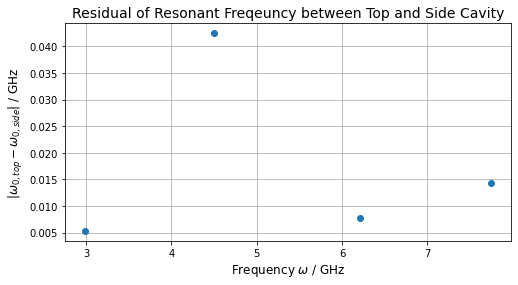

In [6]:
data_list = []

for i, scalar_name in enumerate(scalar_names):
    data = scalar_data[i]
    if i == 0:
        data = np.delete(data, 4,1)
    if i == 1:
        # delete peak with small resonance
        data = np.delete(data, 2,1)
        # print(data)
    # resonant frequency, reflection coefficient
    res_freq = data[0,:]
    rho_res = data[1,:]
    rho_res_err = data[2,:]

    # kappa, rho at half-FWHM evaluated from in-lab
    kappa = data[4,:]   # so we used the kappa for rho < 0 for all analysis
    rho_hfwhm = data[6,:]  # we used the negative rho values for all of our analysis
    rho_hfwhm_err = data[8,:]   # from measurement

    # measured half-FWHM
    half_fwhm = data[7,:] * 0.001   # convert to GHz

    # calculate loaded and unloaded quality factor
    Q = Q_factor(res_freq, half_fwhm)
    Q0 = Q0_factor(Q, kappa)   # abs necessary, otherwise Q-factor is negative

    # uncertainties, evaluated from error propagation
    kappa_unc = kappa_err(rho_res, rho_res_err)
    rho_hfwhm_unc = np.sqrt(refl_hfwhm_err(kappa, kappa_unc)**2. + rho_hfwhm_err**2.)  # include measurement uncertainty
    Q_unc = Q_err(res_freq, freq_err, half_fwhm, np.sqrt(2) * freq_err)
    Q0_unc = Q0_err(Q, Q_unc, kappa, kappa_unc)

    # print resonant frequencies:
    print("Resonant frequencies / GHz for {0} coupling: ".format(scalar_name), res_freq)
    # print Residual with the analytical modes

    # remove the 4th resonant mode for side coupling since it is not in measured resonant mode
    res_freq_thr_temp = res_freqs_thr

    if i == 1:
        res_freq_thr_temp = np.delete(res_freq_thr_temp, 3)
    

    norm_residual = np.abs(res_freq - res_freq_thr_temp)
    print("Residual with Theoretical values: ", norm_residual, "\n")

        # store all in dictionary
    data_dict = {
        "res_freq":res_freq,
        "rho_res":rho_res,
        "rho_res_err":rho_res_err,
        "kappa":kappa,
        "kappa_err":kappa_unc,
        "rho_hfwhm":rho_hfwhm,
        "rho_hfwhm_err": rho_hfwhm_unc,
        "half_fwhm":half_fwhm,
        "fwhm":half_fwhm * 2,
        "Q":Q,
        "Q_err":Q_unc,
        "Q0":Q0,
        "Q0_err":Q0_unc,
        "residual":norm_residual
    }

    data_list.append(data_dict)

# print difference between resonant frequency for top and side coupling
a = data_list[0]["res_freq"]
a = np.delete(a, 3)
print("Differnce in resonance frequency between top and side coupling : ", np.abs(a - data_list[1]["res_freq"]))

fig_path = os.path.join(os.getcwd(), "figures")

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(data_dict["res_freq"], np.abs(a - data_list[1]["res_freq"]), linestyle="", marker="o")

ax.set_xlabel("Frequency $\omega$ / GHz", fontsize=12)
ax.set_ylabel("$|\omega_{{0, top}} - \omega_{{0, side}}|$ / GHz", fontsize=12)
ax.set_title("Residual of Resonant Freqeuncy between Top and Side Cavity", fontsize=14)
ax.grid()
# ax.legend(prop={"size":12})
plt.savefig("figures/scalar_residual_topside.png", dpi=300, bbox_per_inches="tight")

In [6]:
# export values to csv
import pandas as pd

fig_path = os.path.join(os.getcwd(), "figures")


for i, data_dict in enumerate(data_list):
    fname = "scalar_values_{0}.csv".format(scalar_names[i])

    df = [pd.DataFrame({ k : v }) for k, v in data_dict.items()]
    df = pd.concat(df, axis=1)

    df.to_csv(os.path.join(fig_path, fname), index=False) 
    # with open(os.path.join(fig_path, fname), "w") as f:
    #     w = csv.writer(f)
    #     # w.writeheader()
    #     w.writerows(data_dict.items())

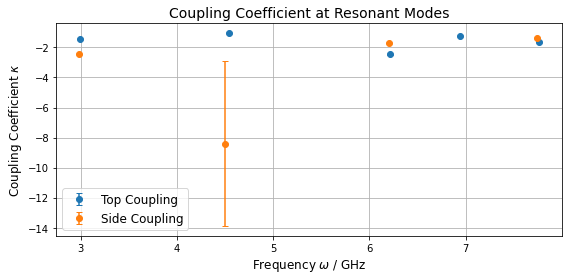

In [6]:
# plot each quantity against resonant frequency for both coupling 

labels = ["Top Coupling", "Side Coupling"]

# coupling coefficient
fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)

for i, data_dict in enumerate(data_list):
    # if i == 1:
    #     data_dict["res_freq"] = np.delete(data_dict["res_freq"], 2)
    #     data_dict["kappa"] = np.delete(data_dict["kappa"], 2)
    #     data_dict["kappa_err"] = np.delete(data_dict["kappa_err"], 2)

    ax.errorbar(data_dict["res_freq"], data_dict["kappa"], yerr=data_dict["kappa_err"], linestyle="", marker="o", capsize=3, label=labels[i])

ax.set_xlabel("Frequency $\omega$ / GHz", fontsize=12)
ax.set_ylabel("Coupling Coefficient $\kappa$", fontsize=12)
ax.set_title("Coupling Coefficient at Resonant Modes", fontsize=14)
ax.grid()
ax.legend(prop={"size":12})

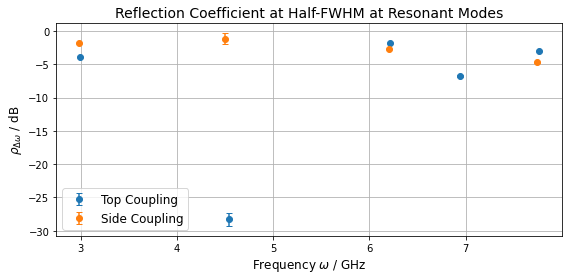

In [7]:
# rho at half-FWHM
fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)

for i, data_dict in enumerate(data_list):
    # if i == 1:
        # data_dict["res_freq"] = np.delete(data_dict["res_freq"], 2)
        # data_dict["rho_hfwhm"] = np.delete(data_dict["rho_hfwhm"], 2)
        # data_dict["rho_hfwhm_err"] = np.delete(data_dict["rho_hfwhm_err"], 2)

    ax.errorbar(data_dict["res_freq"], data_dict["rho_hfwhm"], yerr=data_dict["rho_hfwhm_err"], linestyle="", marker="o", capsize=3, label=labels[i])

ax.set_xlabel("Frequency $\omega$ / GHz", fontsize=12)
ax.set_ylabel(r"$\rho_{{\Delta \omega}}$ / dB", fontsize=12)
ax.set_title("Reflection Coefficient at Half-FWHM at Resonant Modes", fontsize=14)
ax.grid()
ax.legend(prop={"size":12})


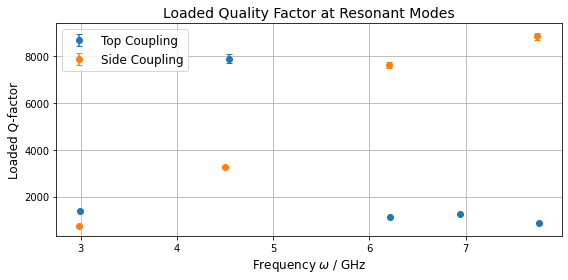

In [8]:
# Q-factor
fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)

for i, data_dict in enumerate(data_list):
    # if i == 1:
        # data_dict["res_freq"] = np.delete(data_dict["res_freq"], 2)
        # data_dict["rho_hfwhm"] = np.delete(data_dict["rho_hfwhm"], 2)
        # data_dict["rho_hfwhm_err"] = np.delete(data_dict["rho_hfwhm_err"], 2)

    ax.errorbar(data_dict["res_freq"], data_dict["Q"], yerr=data_dict["Q_err"], linestyle="", marker="o", capsize=3, label=labels[i])

ax.set_xlabel("Frequency $\omega$ / GHz", fontsize=12)
ax.set_ylabel("Loaded Q-factor", fontsize=12)
ax.set_title("Loaded Quality Factor at Resonant Modes", fontsize=14)
ax.grid()
ax.legend(prop={"size":12})


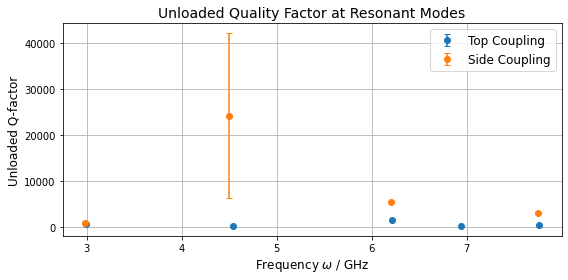

In [9]:
# Q-factor
fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)

for i, data_dict in enumerate(data_list):
    # if i == 1:
        # data_dict["res_freq"] = np.delete(data_dict["res_freq"], 2)
        # data_dict["rho_hfwhm"] = np.delete(data_dict["rho_hfwhm"], 2)
        # data_dict["rho_hfwhm_err"] = np.delete(data_dict["rho_hfwhm_err"], 2)

    ax.errorbar(data_dict["res_freq"], data_dict["Q0"], yerr=data_dict["Q0_err"], linestyle="", marker="o", capsize=3, label=labels[i])

ax.set_xlabel("Frequency $\omega$ / GHz", fontsize=12)
ax.set_ylabel("Unloaded Q-factor", fontsize=12)
ax.set_title("Unloaded Quality Factor at Resonant Modes", fontsize=14)
ax.grid()
ax.legend(prop={"size":12})


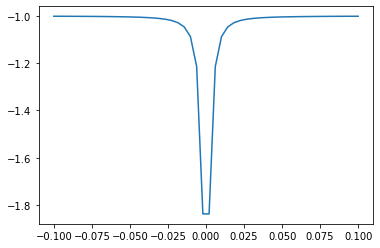

In [10]:
delta_freq_arr = np.linspace(-0.1, 0.1)
rho_dfreq = rho_scalar(delta_freq_arr, res_freq[0], kappa[0], Q0[0])

plt.plot(delta_freq_arr, -rho_dfreq)

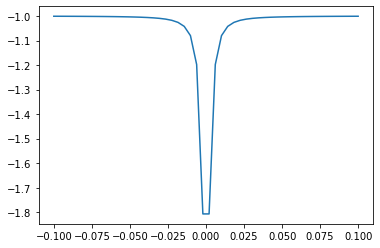

In [11]:
delta_freq_arr = np.linspace(-0.1, 0.1)



rho_dfreq = rho_scalar(delta_freq_arr, 2.848, kappa[0], Q0[0])

plt.plot(delta_freq_arr, -rho_dfreq)